In [1]:
import json

data = []
for name in ["train", "test", "dev"]:
    with open(f"3class/{name}.json", encoding="utf-8") as file:
        data = data + json.load(file)

In [2]:
import pandas as pd

data = pd.DataFrame(data)

In [3]:
data.head()

,sent_id,text,label
0,201911-01-01,Philips 190G6,Neutral
1,201911-02-01,Med integrerte høyttalere som på ingen måte er...,Neutral
2,201911-02-02,Eller bedrar skinnet ?,Negative
3,201911-03-01,"De fleste skjermer har et diskret design , med...",Neutral
4,201911-03-02,Men 190G6 fra Philips er en helt annen historie .,Neutral


<AxesSubplot:>

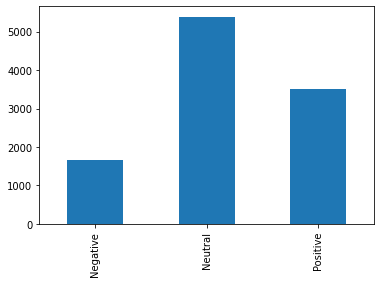

In [4]:
data["label"].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

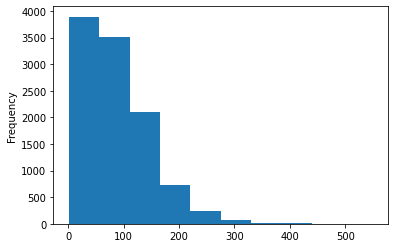

In [5]:
data["text"].str.len().plot.hist()

In [6]:
data["text"] = data["text"].str.lower()
data["text"] = data["text"].str.strip()

In [7]:
data["text"].head()

0                                        philips 190g6
1    med integrerte høyttalere som på ingen måte er...
2                               eller bedrar skinnet ?
3    de fleste skjermer har et diskret design , med...
4    men 190g6 fra philips er en helt annen historie .
Name: text, dtype: object

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data["text"].values)

X = tokenizer.texts_to_sequences(data["text"].values)
X = pad_sequences(X)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation="softmax"))

In [10]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 75, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 75, 256)           525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [11]:
y = pd.get_dummies(data["label"]).values

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
#from keras.callbacks import EarlyStopping

#early_stop = EarlyStopping(monitor="val_acc", mode="max", patience=5)

epochs = 10
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/10
370/370 [==============================] - 297s 790ms/step - loss: 0.9438 - accuracy: 0.5519 - val_loss: 0.9001 - val_accuracy: 0.5963
Epoch 2/10
370/370 [==============================] - 305s 824ms/step - loss: 0.7377 - accuracy: 0.6891 - val_loss: 0.8801 - val_accuracy: 0.6139
Epoch 3/10
370/370 [==============================] - 307s 829ms/step - loss: 0.5382 - accuracy: 0.7953 - val_loss: 0.9918 - val_accuracy: 0.6078
Epoch 4/10
370/370 [==============================] - 308s 832ms/step - loss: 0.3988 - accuracy: 0.8556 - val_loss: 1.0875 - val_accuracy: 0.5957
Epoch 5/10
370/370 [==============================] - 309s 836ms/step - loss: 0.2903 - accuracy: 0.8987 - val_loss: 1.3031 - val_accuracy: 0.5889
Epoch 6/10
370/370 [==============================] - 305s 825ms/step - loss: 0.2074 - accuracy: 0.9241 - val_loss: 1.3957 - val_accuracy: 0.5761
Epoch 7/10
370/370 [==============================] - 320s 865ms/step - loss: 0.1610 - accuracy: 0.9437 - val_loss: 1.6399 -

In [14]:
from datetime import datetime

model.save(f"models/SA-RNN-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

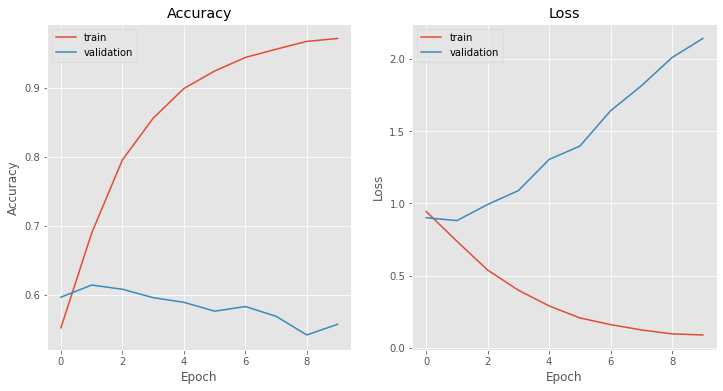

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy and loss in the same figure but in two different plots
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
import numpy as np

predictions = model.predict(X_test)
pos_count, neg_count, neu_count = 0, 0, 0
true_pos_count, true_neg_count, true_neu_count = 0, 0, 0

for i, prediction in enumerate(predictions):
    if np.argmax(prediction) == 2:
        pos_count += 1
    elif np.argmax(prediction) == 1:
        neg_count += 1
    else:
        neu_count += 1

    if np.argmax(y_test[i]) == 2:
        true_pos_count += 1
    elif np.argmax(y_test[i]) == 1:
        true_neg_count += 1
    else:
        true_neu_count += 1

print(f"Positive: {pos_count}")
print(f"Negative: {neg_count}")
print(f"Neutral: {neu_count}")
print(f"True Positive: {true_pos_count}")
print(f"True Negative: {true_neg_count}")
print(f"True Neutral: {true_neu_count}")

Positive: 1076
Negative: 1634
Neutral: 460
True Positive: 1069
True Negative: 1604
True Neutral: 497
